In [2]:
begin
    using Pkg
    Pkgs = ["CSV", "DataFrames", "Ipopt", "JuMP", "Plots", "DelimitedFiles", "LaTeXStrings", "SparseArrays"]
    for p in Pkgs
        if Base.find_package(p) == nothing
            Pkg.add(p)
        end
    end
end
    using CSV, DataFrames, Ipopt, JuMP, Plots, DelimitedFiles, LaTeXStrings, SparseArrays

In [4]:
BusData = CSV.read("data/bus.csv", DataFrame)
GenData = CSV.read("data/gen.csv", DataFrame)
GenCostData = CSV.read("data/gencost.csv", DataFrame)
BranchData = CSV.read("data/branch.csv", DataFrame)
DemandData = CSV.read("data/demand.csv", DataFrame)
SolarGenData = CSV.read("data/solar.csv", DataFrame)

,1,2,3,4,5,6,7,8,9,10,11
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,1.44,12.06,25.02,36.9


In [5]:
println(DemandData)

2×24 DataFrame
 Row │ 1        2        3        4        5        6        7        8        9        10       11       12       13       14       15       16       17       18       19       20       21       22       23       24      
     │ Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64 
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │  0.0       0.0      0.0      0.0      0.0      0.0      0.0       0.0     0.0      0.0     0.0      0.0       0.0     0.0       0.0      0.0     0.0       0.0      0.0       0.0    0.0       0.0     0.0        0.0
   2 │ 20.2195   19.075   18.312   17.549   17.549   17.549   20.601    22.89   26.235   27.468

In [6]:
BranchData

,fbus,tbus,r,x,b,rateA,rateB,rateC,ratio
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,2.0,0.0,0.1,0.0,30.0,250.0,250.0,0.0


In [7]:
Gens = 1:size(GenData)[1]
Buses = 1:size(BusData)[1]
T = 1:8640

1:8640

In [8]:
# # Generate demand data
# Demand = []
# for t in T
#     append!(Demand, 10*sin(0.26 * (t + 10)) + 25)
# end
# #@show Demand[1]
# #plot(Demand)
# DemandData = DataFrame(b1 = Float64[], b2 = Float64[])

# for i in T
#     push!(DemandData, (0.0, Demand[i]))
# end 

# DemandData = DataFrame([[names(DemandData)]; collect.(eachrow(DemandData))], [:column; Symbol.(axes(DemandData, 1))])
# DemandData = select!(DemandData, Not(:column))
# plot(Demand, label="Demand")#, xlim = [1, 24], ylim = [0, 40])

In [9]:
GenCostData

,2,startup,shutdown,n,c2,c1,c0
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2.0,1500.0,0.0,3.0,0.0,100.0,0.0
2,2.0,2000.0,0.0,3.0,0.0,160.0,0.0


In [10]:
BusData

,bus_i,type,Pd,Qd,Gs,Bs,area,Vm,Va
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,2.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [11]:
NBuses = size(BusData)[1]
NLines = size(BranchData)[1]
Y = zeros(Complex, NBuses, NBuses)
b = zeros(NBuses, NBuses)
X = zeros(NBuses, NBuses)
BranchData[!,"fbus"] = convert.(Int64, BranchData[!,"fbus"])
BranchData[!,"tbus"] = convert.(Int64, BranchData[!,"tbus"])

for row in eachrow(BranchData)
    # Non-diagonal elements of Y
    Y[row["fbus"], row["tbus"]] = Y[row["fbus"], row["tbus"]] - (1 / (row["r"] + im*row["x"])) 
    Y[row["tbus"], row["fbus"]] = Y[row["tbus"], row["fbus"]] - (1 / (row["r"] + im*row["x"]))
    
    # Diagonal elements of Y
    Y[row["fbus"], row["fbus"]] = Y[row["fbus"], row["fbus"]] + (1 / (row["r"] + im*row["x"])) 
    Y[row["tbus"], row["tbus"]] = Y[row["tbus"], row["tbus"]] + (1 / (row["r"] + im*row["x"]))
    
    # Shunt susceptance
    b[row["fbus"], row["tbus"]] = row["b"]
    b[row["tbus"], row["fbus"]] = row["b"]
    
    # Reactence matrix
    X[row["fbus"], row["tbus"]] = row["x"]
    X[row["tbus"], row["fbus"]] = row["x"]
end

G = real(Y)
B = imag(Y)

Lines = [(row["fbus"], row["tbus"]) for row in eachrow(BranchData)]

1-element Vector{Tuple{Int64, Int64}}:
 (1, 2)

In [12]:
Y

2×2 Matrix{Complex}:
 0.0-10.0im  0.0+10.0im
 0.0+10.0im  0.0-10.0im

In [13]:
# Lines' apparent power limits

S = zeros(NBuses,NBuses)
for i in 1:NLines
    S[BranchData[i,:fbus],BranchData[i,:tbus]] = BranchData[i,:rateA] # Choose rateA column because it is for the long-term case
    S[BranchData[i,:tbus],BranchData[i,:fbus]] = BranchData[i,:rateA]
end

In [39]:
#DC OPF
function DCPF(G, B, b, S, BusData, DemandData, GenData, Gens, Buses, T)
    """
    This function creates a JuMP model for Optimal Power Flow (OPF) problem with provided parameters of power grid
    
    Arguments:
        G (Matrix{Real})        : conductance matrix of grid -- real part of admittance matrix
        B (Matrix{Real})        : susceptance matrix of grid -- imaginary part of admittance matrix
        b (Matrix{Float64})     : shunt matrix for lines
        S (Matrix{Float64})     : line flow limits matrix
        BusData (DataFrame)     : contains information on buses: power demands and voltage magnitude limits
        GenData (DataFrame)     : contains information on generators: generation limits and 
                                  quadratic cost function's coefficients
        Gens (UnitRange{Int64}) : indices of generators
        Buses (UnitRange{Int64}): indices of buses
    Returns:
        
    """
    
    m = Model(Ipopt.Optimizer)
    #set_optimizer_attribute(m, "max_cpu_time", 240.0)
    set_optimizer_attribute(m, "max_iter", 400)
    set_optimizer_attribute(m, "acceptable_tol", 1.0)
    
    #set_optimizer_attribute(m, "max_wall_time", 30.0) - should limit the real time but doesn't work
    
    # Battery parameters
    Emax0 = 100.0      # Initial capacitance
    Emin = 10.0        # Minimum capacity
    η_ch = 0.975         # Charging efficiency
    η_disch = 0.975     # Discharging efficiency
    SoC = 0.5
    
    
    # Idling degradation
    # Numbers from the article are multiplied by 10 to increase the speed of degradation
    A_idl = 0.00000602 #* 10000
    B_idl = 0.0000135  #* 10000
    C_idl = 0.0000185  #* 10000
    
    # Cycling degradation
    A_cyc = -0.0000472 #* 10000
    B_cyc =  0.0000962 #* 10000
    
    γ_idl = A_idl * (SoC)^2 + B_idl * (SoC) + C_idl
    
    print()
    # Variables
    
    ## Voltages
    @variable(m, BusData[i, :Vmin] ≤ v[i in Buses, t in T] ≤ BusData[i, :Vmax], start = 1.0)
    @variable(m, δ[i in Buses, t in T], start = 0.0)
    
    ## Power generations
    @variable(m, GenData[i, :Pmin] ≤ p[i in Gens, t in T] ≤ GenData[i, :Pmax])
    @variable(m, GenData[i, :Qmin] ≤ q[i in Gens, t in T] ≤ GenData[i, :Qmax])
        
    ## Battery
    @variable(m, Emax[t in T], start = Emax0)
    @variable(m, E[t in T], start = Emin)
    @variable(m, 0.0 ≤ Pch[i in Buses, t in T] ≤ 35.0)
    @variable(m, 0.0 ≤ Pdisch[i in Buses, t in T] ≤ 40.0)
    @variable(m, γ_idl[t in T])
    @variable(m, γ_cyc[t in T])
    #@variable(m, SoC[t in T])
    @variable(m, DoD[t in T])
    @variable(m, y[t in T])     # Ratio of the cycle, y = (Pch + Pdis)/Emax0
    @variable(m, 0.0 ≤ Pdump[i in Buses, t in T])
    @variable(m, sum_y[t in T])
    #@variable(m, batteryIsOn[t in T], start = 1.0)
    
    ### No simultaneous charge and discharge
    @constraint(m, sum_yt[t in 2:size(T)[1]], sum_y[t] == sum_y[t - 1] + y[t] * γ_cyc[t])
 
    
    ### SoC and DoD definitions
    #@constraint(m, SoC_definition[t in T], SoC[t] == E[t] / Emax0)
    @constraint(m, DoD_definition[t in T], DoD[t] == 1 - E[t]/Emax0)
    @constraint(m, y_definition[t in T], y[t] == (Pch[2, t] + Pdisch[2, t]) / Emax0)
    
    
    ### Initialization of parameters in initial condition
    @constraint(m, Et_init, E[1] == Emin)
    @constraint(m, Emax_init, Emax[1] == Emax0)
    @constraint(m, Pch2_init, Pch[2, 1] == 0.0)
    @constraint(m, Pdisch2_init, Pdisch[2, 1] == 0.0)
    @constraint(m, y_sum_init, sum_y[1] == 0.0)
    
    ### No battery at bus #1
    @constraint(m, Pch1[t in T], Pch[1, t] == 0.0)      
    @constraint(m, Pdisch1[t in T], Pdisch[1, t] == 0.0) 
    
    ### Capacitance limit
    @constraint(m, MaxCapacity[t in T], E[t] ≤ Emax[t])
    @constraint(m, MinCapacity[t in T], Emin ≤ E[t])
    
    ### Degradation model
    #@constraint(m, IdlingDegradation[t in T],  γ_idl[t] == A_idl * (SoC)^2 + B_idl * (SoC) + C_idl)
    @constraint(m, CyclingDegradation[t in T], γ_cyc[t] == A_cyc * (DoD[t])^2 + B_cyc * (DoD[t]))
    @NLconstraint(m, Degradation[t in T],                      
                Emax[t] == Emax0 * (1 - (0.000026755 + sum_y[t])))

    
    @constraint(m, Et[t in 2:size(T)[1]], E[t] == E[t - 1] - 
                                        ((Pdisch[2, t - 1] / η_disch) -  (η_ch * Pch[2, t - 1]))) 
    
    @constraint(m, Pdisch21[t in T], E[t] - Pdisch[2, t] / η_disch ≥ Emin )
    @constraint(m, Pch21[t in T], E[t] + η_ch * Pch[2, t] ≤ Emax[t] )
    
    #@NLconstraint(m, OnOff[t in T], batteryIsOn[t] == 1 / (1 + exp(-2000 * (Emax[t] - Emin))))
    
    
    
    ## Power flows
    @variable(m, pij[i in Buses, j in Buses, t in T; (i != j) && (abs(Y[i, j]) > 0.)])
    @variable(m, qij[i in Buses, j in Buses, t in T; (i != j) && (abs(Y[i, j]) > 0.)])
    
    #Constraints
    
    ##Slack bus
    @constraint(m, δ_slack[t in T], δ[1, t] == 0.0)
    
    ## Power flow through lines
    @NLconstraint(m, p_line[i in Buses, j in Buses, t in T; (i != j) && (abs(Y[i, j]) > 0.)],
                     pij[i, j, t] == (δ[i, t] - δ[j, t]) / X[i, j]
    )
    @NLconstraint(m, q_line[i in Buses, j in Buses, t in T; (i != j) && (abs(Y[i, j]) > 0.)],
                     qij[i, j, t] == (v[i, t] - v[j, t]) / X[i, j] 
    )
    ## Nodal balance
    @NLconstraint(m, P_bus[i in Buses, t in T],
                    sum(p[g, t] for g in Gens if (g == i)) - DemandData[i, (t-1) % 24 + 1] +
                    SolarGenData[i, (t-1) % 24 + 1] - Pch[i, t] + Pdisch[i, t] - Pdump[i, t] - 
                    sum(pij[i, j, t] for j in Buses if ((i != j) && (abs(Y[i, j]) > 0.))) == 0
                    
    )

    
    @NLconstraint(m, Q_bus[i in Buses, t in T],
                    sum(q[g, t] for g in Gens if g == i) - BusData[i, :Qd] - 
                    sum(qij[i, j, t] for j in Buses if ((i != j) && (abs(Y[i, j]) > 0.))) == 0
    )
    
    ## Line limits
    @NLconstraint(m, S_max[i in Buses, j in Buses, t in T; (i != j) && (abs(Y[i, j]) > 0.)],
                    pij[i, j, t]^2 + qij[i, j, t]^2 ≤ 100.0^2  #S[i, j]^2
        
    )
    
    ## Phase angle difference
    @constraint(m, δ_diff[i in Buses, j in Buses, t in T; (i != j) && (abs(Y[i, j]) > 0.)],
                    -2*pi ≤ δ[i, t] - δ[j, t] ≤ 2*pi
    )
    
    # Objective
    @objective(m, Min, sum(p[g, t]^2 * GenCostData[g, :c2] + 
                           p[g, t]^1 * GenCostData[g, :c1] + 
                                       GenCostData[g, :c0]
                           for g in Gens for t in T) + Emax0 * 137)
    
    # Solve
    JuMP.optimize!(m)
    return m
end

DCPF (generic function with 1 method)

In [ ]:
@time mDCPF = DCPF(G, B, b, S, BusData, DemandData, GenData, Gens, Buses, T)

In [ ]:
#@show mDCPF[:S_max]
@show objective_value(mDCPF)
@show T
x = value.(mDCPF[Symbol("Emax")])

In [31]:
p = value.(mDCPF[Symbol("p")])
pij = value.(mDCPF[Symbol("pij")])
qij = value.(mDCPF[Symbol("qij")])
E = value.(mDCPF[Symbol("E")])
Emax = value.(mDCPF[Symbol("Emax")])
pdis = value.(mDCPF[Symbol("Pdisch")])
pch = value.(mDCPF[Symbol("Pch")])
pdump = value.(mDCPF[Symbol("Pdump")])

S_max = []
for i in eachindex(pij)
   S_i = pij[i]^2 + qij[i]^2
   append!(S_max, S_i)
end

BatteryPower = DataFrame(t = Int64[], Pcharge = Float64[], Pdischarge = Float64[])

results = DataFrame(P2 = Float64[], P1 = Float64[], E = Float64[], 
                    Pch = Float64[], Pdis = Float64[], Demand = Float64[], 
                    Emax = Float64[], SolarGen = Float64[], Pdumped = Float64[])

for i in T
    push!(results, round.(tuple(p[2, i], p[1, i], E[i], pch[2, i], pdis[2, i], 
                                DemandData[!,(i-1)%24 + 1][2], Emax[i], SolarGenData[!,(i-1)%24 + 1][2],pdump[2, i] ), digits=2))
    
    push!(BatteryPower, tuple(i ,pch[2, i], pdis[2, i] ))
end

In [32]:
results

,P2,P1,E,Pch,Pdis,Demand,Emax,SolarGen,Pdumped
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,20.22,10.0,0.0,0.0,20.22,200.0,0.0,0.0
2,0.0,19.08,10.0,0.0,0.0,19.08,200.0,0.0,0.0
3,0.0,18.31,10.0,0.0,0.0,18.31,200.0,0.0,0.0
4,0.0,17.55,10.0,0.0,0.0,17.55,200.0,0.0,0.0
5,0.0,17.55,10.0,0.0,0.0,17.55,200.0,0.0,0.0
6,0.0,17.55,10.0,0.0,0.0,17.55,200.0,0.0,0.0
7,0.0,20.6,10.0,0.0,0.0,20.6,200.0,0.0,0.0
8,0.0,21.45,10.0,0.0,0.0,22.89,200.0,1.44,0.0
9,0.0,14.17,10.0,0.0,0.0,26.24,200.0,12.06,0.0


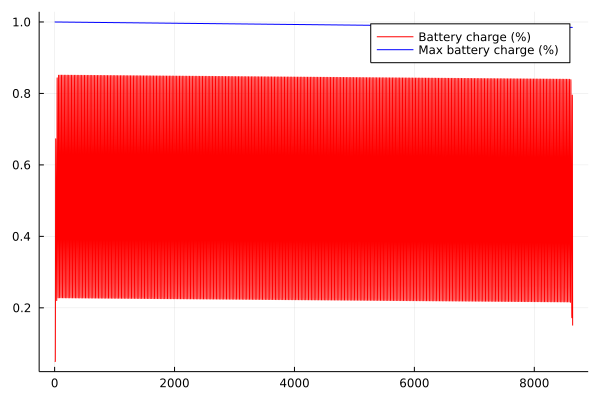

In [33]:
plot(E / 200, label="Battery charge (%)", color=:red)
plot!(Emax / 200, label="Max battery charge (%)", color=:blue)

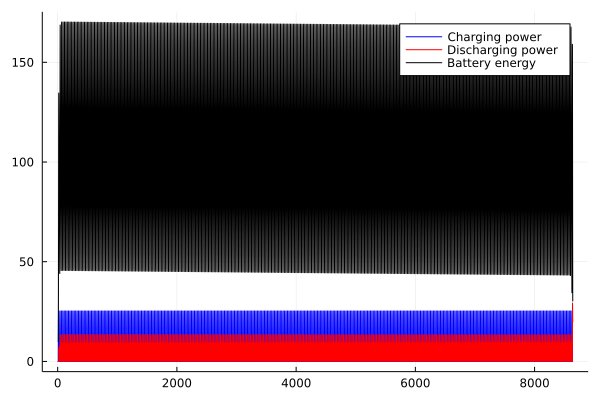

In [34]:
plot(results[!, :Pch], label="Charging power", color=:blue)
plot!(results[!, :Pdis], label="Discharging power", color=:red)
plot!(results[!, :E], label="Battery energy", color=:black)

In [35]:
# plot(results[!, :Pch], label="Charging power", color=:blue)
# plot!(results[!, :Pdis], label="Discharging power", color=:red)
plot(results[!, :E], label="Battery energy", title="Optimal daily dispatch without degradation", color=:red)
plot!(xlabel = "Time [hours]", ylabel = "Battery energy [kWh]")
# plot!(results[!, :Demand], label="Demand", color=:darkviolet)
# plot!(results[!, :P2], label="Generated power (expensive gen)", color=:lightgreen)
# plot!(results[!, :P1], label="Generated power (cheap gen)", color=:green)
# plot!(results[!, :SolarGen], label="Solar power", color=:orange)
# plot!(results[!, :Pdumped], label="Dumpped", color=:black)
plot!(xlim = [24, 48], ylim = [0, 200])
savefig("Optimal daily dispatch without degradation.png")

In [1]:
T

LoadError: UndefVarError: T not defined

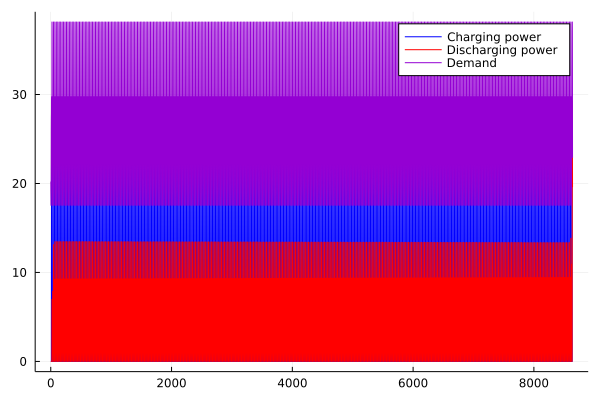

In [36]:
plot(results[!, :Pch], label="Charging power", color=:blue)
plot!(results[!, :Pdis], label="Discharging power", color=:red)
plot!(results[!, :Demand], label="Demand", color=:darkviolet)

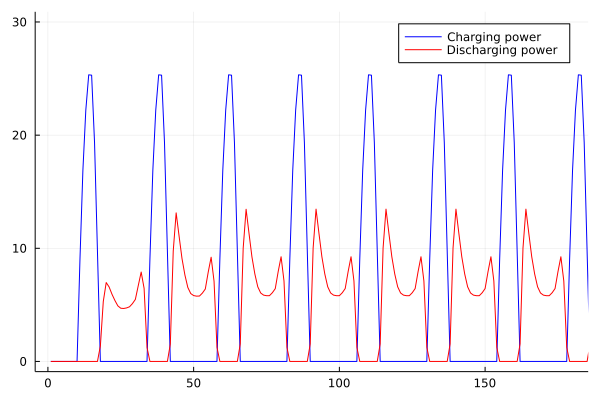

In [37]:
plot(results[!, :Pch], label="Charging power", color=:blue)
plot!(results[!, :Pdis], label="Discharging power", color=:red)
plot!(xlim = [1, 180], ylim = [0, 30])

In [38]:
#CSV.write("Model#1.csv", results)
CSV.write("Model#1_1_year_200KWh_2.csv", BatteryPower)

"Model#1_1_year_200KWh_2.csv"

In [ ]:
BatteryPower

In [ ]:
sumD = 0.0
sumG = 0.0
sumG1 = 0.0
for i in 1:24
    sumD += DemandData[2,i]
    sumG += SolarGenData[2,i]
    if DemandData[2,i] ≥ SolarGenData[2,i]
        sumG1 += DemandData[2,i] - SolarGenData[2,i]
    end
end 
@show sumD
@show sumG1*0.05*30
sumG